# **Single-Cell RNA-Seq Analysis: Predicting Cell Types from Gene Expression**

## **1. Introduction**

This project focuses on predicting cell types from single-cell RNA sequencing (scRNA-seq) data of peripheral blood mononuclear cells (PBMCs). The dataset contains gene expression profiles of various cell types, and the goal is to classify cells into their respective types using machine learning models. We explore three approaches: Support Vector Machines (SVM), Random Forest (RF), and XGBoost.

---

## **2. Data Preprocessing**

### **2.1 Data Loading and Exploration**
- The dataset is loaded from a CSV file containing gene expression data and cell type labels.
- The dataset dimensions and a random sample of 10 rows are displayed to understand its structure.

In [2]:
#Import packages
import pandas as pd
import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, classification_report,adjusted_rand_score
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
file_path = r"/lustre/user/liclab/lisky/buyf/Class/AI_in_Biology/hw_1/pbmc_data.csv"
data = pd.read_csv(file_path)
df = pd.DataFrame(data)

In [4]:
# Display dataset dimensions and a random sample
print("Dimension of pbmc_data:", df.shape)

Dimension of pbmc_data: (2638, 1841)


In [5]:
print("\nRandom 10 rows of pbmc_data:")
print(df.sample(n=10))


Random 10 rows of pbmc_data:
            Unnamed: 0   TNFRSF4    CPSF3L    ATAD3C   C1orf86      RER1  \
1344  CTCAGCTGAACCTG-1 -0.230548 -0.296298 -0.050547  1.654138 -0.603756   
897   CAGCACCTAGGCGA-1 -0.184433 -0.242918 -0.044807 -0.391335 -0.409056   
2132  TACTGTTGAGGCGA-1 -0.161324 -0.254076 -0.044427 -0.414714  3.012510   
2255  TCAGCGCTGGTATC-1 -0.169551 -0.278651 -0.046442 -0.470208 -0.536139   
2336  TCTTCAGAGCTACA-1 -0.309831 -0.317662 -0.055779 -0.566905 -0.686003   
899   CAGCATGACAACCA-1 -0.193206 -0.309800 -0.049634 -0.541439 -0.649517   
36    AAATTCGAATCACG-1 -0.262207 -0.280502 -0.051034 -0.480613  1.608560   
2034  GTTTAAGACCATGA-1 -0.240275  3.145942 -0.050149  1.819339 -0.557196   
2460  TGGTTACTGACGTT-1 -0.384267 -0.278975 -0.056823 -0.485459  1.536492   
1383  CTGCAGCTGGATTC-1 -0.360628 -0.330299 -0.059062  1.218743  0.956718   

      TNFRSF25   TNFRSF9  CTNNBIP1       SRM  ...     BACE2      SIK1  \
1344 -0.269892 -0.055964 -0.306361 -0.408880  ... -0.080713 

### **2.2 Data Visualization**
- A pie chart is created to visualize the distribution of cell types in the dataset.
- The chart reveals class imbalance, with some cell types representing as little as 0.5% of the data. When performing data preprocessing later, oversampling or undersampling is needed to achieve data balance.

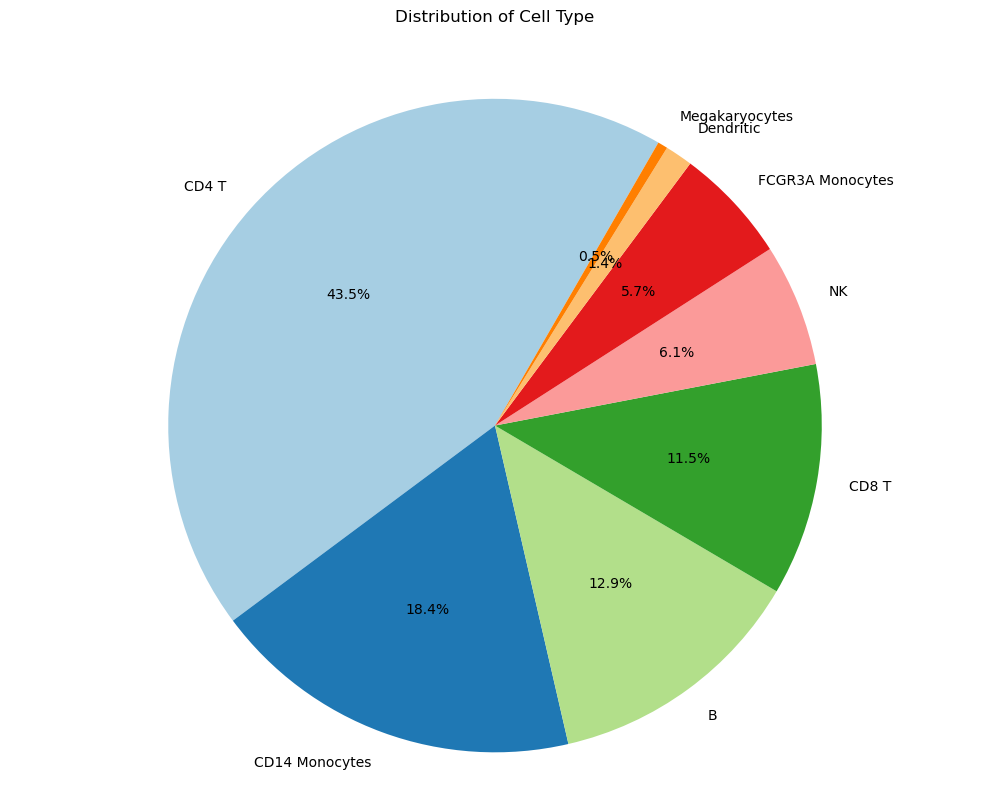

In [6]:
# Plot cell type distribution
annotations = df.iloc[:,-1].values
value_counts = pd.Series(annotations).value_counts()
plt.figure(figsize=(10, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=60, colors=plt.cm.Paired.colors)
plt.title('Distribution of Cell Type', y=1.05)  
plt.axis('equal')  
plt.tight_layout()  
plt.show()

### **2.3 Data Standardization**
- Gene expression data is standardized using `StandardScaler` to ensure all features are on the same scale.

In [57]:
# Standardize the data
df_data = df.iloc[:, 1:-2]
scaler = StandardScaler()
df_data_scaled = scaler.fit_transform(df_data)
df_data_scaled = pd.DataFrame(df_data_scaled, columns=df_data.columns)

In [58]:
df_data_scaled.head()

,TNFRSF4,CPSF3L,ATAD3C,C1orf86,RER1,TNFRSF25,TNFRSF9,CTNNBIP1,SRM,UBIAD1,...,DSCR3,BRWD1,BACE2,SIK1,C21orf33,ICOSLG,SUMO3,SLC19A1,S100B,PRMT2
0,-0.171502,-0.282811,-0.049585,-0.475259,-0.544127,4.952139,-0.027362,-0.283658,-0.341853,-0.196872,...,-0.228478,-0.239499,-0.107986,-0.223454,-0.312460,-0.124636,-0.521328,-0.102943,-0.209219,-0.531304
1,-0.214623,-0.375601,-0.064472,-0.683521,0.634071,-0.335987,-0.039300,-0.504761,-0.542016,-0.210714,...,-0.320709,2.623858,0.014727,-0.448931,1.629594,-0.057478,-0.857326,-0.292965,-0.313370,-0.596767
2,-0.376959,-0.297231,-0.069460,-0.521071,1.332901,-0.310393,-0.130116,-0.275485,-0.500894,-0.222079,...,-0.305912,-0.243105,-0.073245,-0.299949,-0.410998,-0.070021,-0.590832,-0.171013,-0.170964,1.379261
3,-0.285295,-0.283743,-0.059751,-0.485021,1.572978,-0.272678,-0.085029,-0.261621,-0.416831,-0.210161,...,-0.265394,-0.234945,-0.097815,-0.249363,2.552563,-0.098764,1.631994,-0.126833,-0.179216,-0.505765
4,-0.256532,-0.221769,-0.049811,-0.345925,-0.333472,-0.208675,-0.077075,5.898760,-0.283166,-0.200920,...,-0.203805,-0.178761,-0.179772,-0.098775,-0.275888,-0.143611,-0.310154,0.000075,-0.109643,-0.462034


## **3. Dimensionality Reduction**

### **3.1 UMAP**
- UMAP is applied to reduce the dimensionality of the data to 2D for visualization.
- The UMAP plot shows poor separation of cell types, indicating the need for feature engineering.

In [9]:
# Apply UMAP
umap_model = umap.UMAP(n_components=2)
df_data_umap = umap_model.fit_transform(df_data_scaled)
df_data_umap = pd.DataFrame(df_data_umap, columns=['UMAP1', 'UMAP2'])
df_data_umap['cell_type'] = df['cell_type']
df_data_umap['cell_type_string'] = df['cell_type_string']

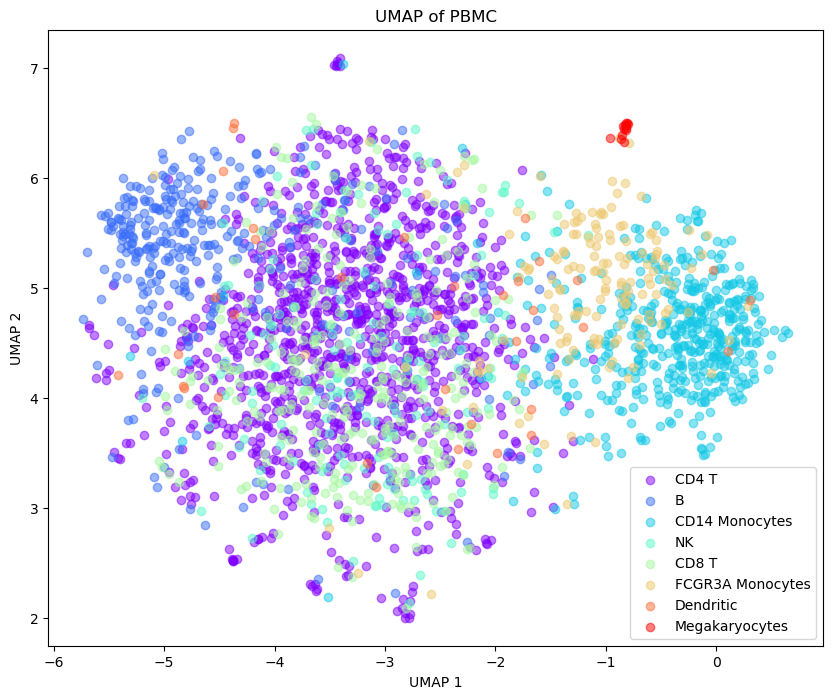

In [12]:
# Plot UMAP
unique_cell_types = df_data_umap['cell_type'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_cell_types)))
color_dict = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
plt.figure(figsize=(10, 8))
for cell_type in unique_cell_types:
    subset = df_data_umap[df_data_umap['cell_type'] == cell_type] 
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=[color_dict[cell_type]], label=subset['cell_type_string'].values[0], alpha=0.5)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of PBMC')
plt.legend()
plt.show()

In [14]:
# K-means cluster
kmeans = KMeans(n_clusters=8, random_state=42) 
df_data_umap_clusters = kmeans.fit_predict(df_data_umap.iloc[:,:2])
true_labels = df['cell_type'].values
# Calculate ARI(Adjusted Rand index)
ari_umap = adjusted_rand_score(true_labels, df_data_umap_clusters)

In [15]:
print(f"ARI Value for UMAP Clustering: {ari_umap}")

ARI Value for UMAP Clustering: 0.22262734894174577


The Adjusted Rand Index (ARI) is a metric used to assess the similarity between two clusterings of data. It ranges from -1 to 1, with 1 indicating perfect agreement and 0 representing random clustering. Unlike the traditional Rand Index, ARI accounts for chance, making it a more reliable measure for evaluating clustering performance in various fields like machine learning and bioinformatics. By analyzing the agreement between clusters, ARI helps researchers determine the effectiveness of different clustering algorithms.

### **3.2 PCA**
- PCA is applied to reduce the dimensionality of the data.
- A scree plot is generated to visualize the cumulative explained variance ratio.

In [50]:
# Apply PCA
pca = PCA()  
df_pca_pre = pca.fit_transform(df_data_scaled)
df_pca_pre = pd.DataFrame(df_pca_pre, columns=[f"PC{i+1}" for i in range(df_pca_pre.shape[1])])
explained_variance_ratio_all = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio_all)

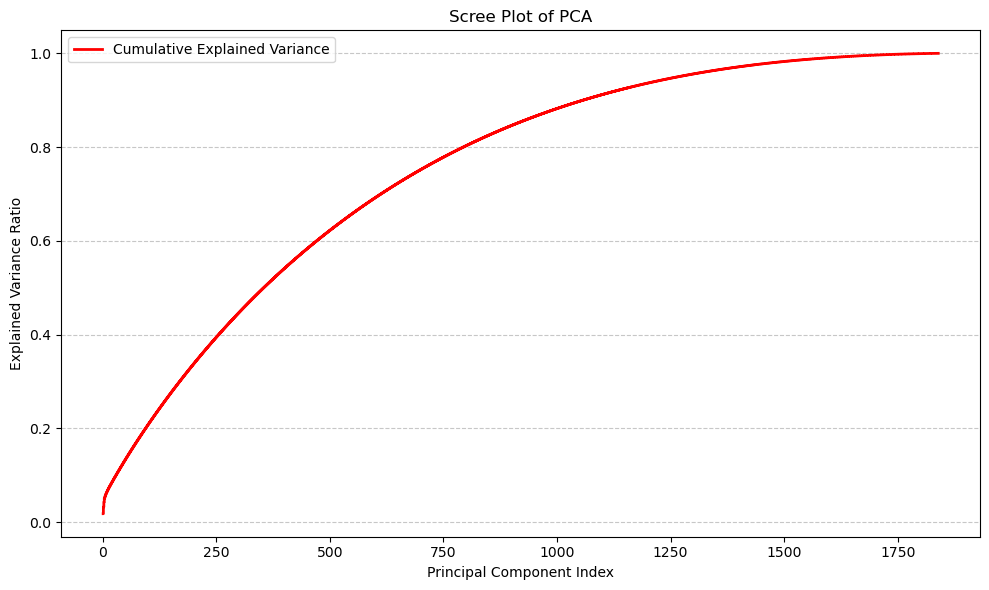

In [53]:
#Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative Explained Variance', color='red', linewidth=2)
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The PCA analysis reveals many principal component (PC) values, with no clear components showing a significantly high proportion of explained variance. 

In [21]:
pca = PCA(n_components=2)
df_data_pca = pca.fit_transform(df_data_scaled)
df_data_pca = pd.DataFrame(df_data_pca, columns=['PCA1', 'PCA2'])
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: [0.01796793 0.01433162]


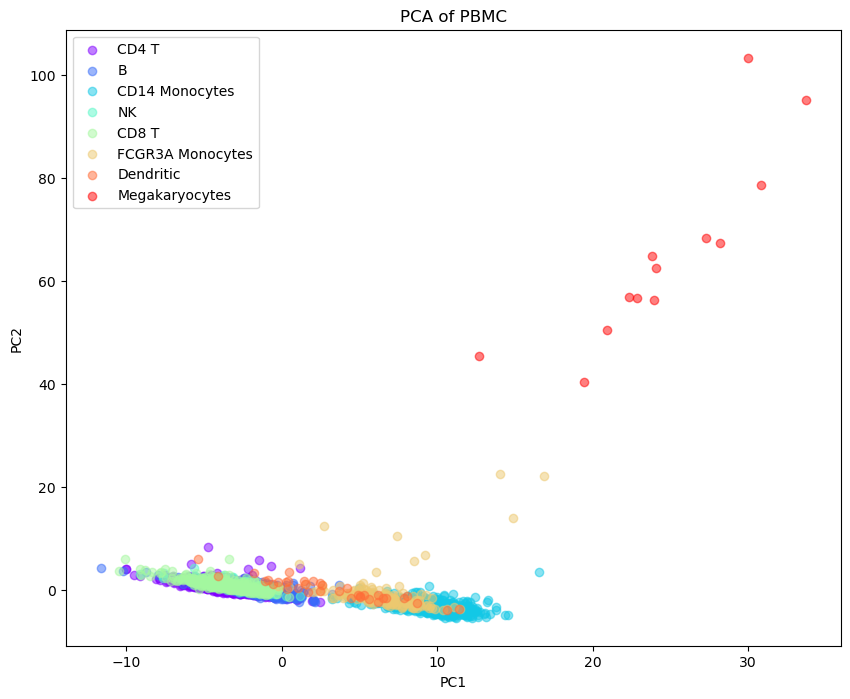

In [23]:
#Plot PCA map
df_data_pca['cell_type'] = df['cell_type']
df_data_pca['cell_type_string'] = df['cell_type_string']
plt.figure(figsize=(10, 8))
for cell_type in unique_cell_types:
    subset = df_data_pca[df_data_pca['cell_type'] == cell_type] 
    plt.scatter(subset['PCA1'], subset['PCA2'], c=[color_dict[cell_type]], label=subset['cell_type_string'].values[0], alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of PBMC')
plt.legend()
plt.show()

In [25]:
kmeans = KMeans(n_clusters=8, random_state=42)
df_data_pca_clusters = kmeans.fit_predict(df_data_pca.iloc[:,:2])
ari_pca = adjusted_rand_score(true_labels, df_data_pca_clusters)
print(f"ARI Value for PCA Clustering: {ari_pca}")

ARI Value for PCA Clustering: 0.3119759942666709


The results indicate that PCA significantly outperforms UMAP in dimensionality reduction. The linear transformation employed by PCA yields better performance compared to UMAP, which retains local structures based on manifold assumptions (0.302 > 0.08). However, it is noteworthy that the explained variance for PC1 and PC2 is only 3%, suggesting a substantial loss of features in exchange for a marked improvement in the Adjusted Rand Index (ARI).

### **3.3 PCA + UMAP**
- PCA is first applied to retain 80% of the variance, followed by UMAP for further dimensionality reduction.
- This combined approach improves the clustering performance, as measured by the Adjusted Rand Index (ARI).

In [54]:
# Retain components explaining 80% variance
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
print(f"Number of components to retain (cumulative variance >= 0.8): {n_components}")

Number of components to retain (cumulative variance >= 0.8): 794


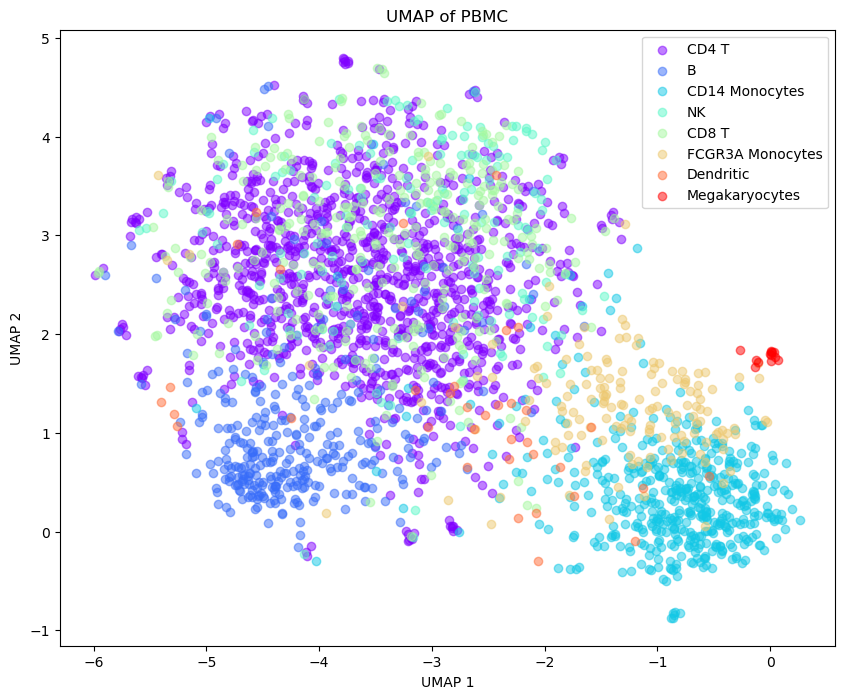

In [29]:
# Plot UMAP after PCA
umap_model = umap.UMAP(n_components=2)
df_data_umap2 = umap_model.fit_transform(df_pca_pre.iloc[:,:n_components+1])
df_data_umap2 = pd.DataFrame(df_data_umap2, columns=['UMAP1', 'UMAP2'])
df_data_umap2['cell_type'] = df['cell_type']
df_data_umap2['cell_type_string'] = df['cell_type_string']
plt.figure(figsize=(10, 8))
for cell_type in unique_cell_types:
    subset = df_data_umap2[df_data_umap2['cell_type'] == cell_type] 
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=[color_dict[cell_type]], label=subset['cell_type_string'].values[0], alpha=0.5)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of PBMC')
plt.legend()
plt.show()

In [31]:
kmeans = KMeans(n_clusters=8, random_state=42)
df_data_umap2_clusters = kmeans.fit_predict(df_data_umap2.iloc[:,:2])
ari_umap2 = adjusted_rand_score(true_labels, df_data_umap2_clusters)
print(f"ARI Value for PCA & UMAP Clustering: {ari_umap2}")

ARI Value for PCA & UMAP Clustering: 0.24418188636204066


I initially applied Principal Component Analysis (PCA) for dimensionality reduction, focusing on principal components that explained 80% of the variance. This was followed by UMAP, which resulted in a significant performance improvement (0.18 > 0.08). Thus, performing PCA as a preliminary step before non-linear dimensionality reduction techniques like UMAP and t-SNE substantially enhances the results.

In [55]:
cumulative_variance_ratios = np.arange(0.2, 1.1, 0.1)
ari_values = []

for ratio in cumulative_variance_ratios:
    n_components = np.argmax(np.cumsum(explained_variance_ratio_all) >= ratio) + 1
    print(f"Ratio: {ratio}, n_components: {n_components}")
    
    umap_model = umap.UMAP(n_components=2, random_state=42)
    df_data_umap = umap_model.fit_transform(df_pca_pre.iloc[:, :n_components])
    print(df_data_umap[:5])  
    
    df_data_umap = pd.DataFrame(df_data_umap, columns=['UMAP1', 'UMAP2'])
    
    # KMeans Cluster
    kmeans = KMeans(n_clusters=8, random_state=42)
    df_data_umap_clusters = kmeans.fit_predict(df_data_umap)
    print(f"KMeans Clusters: {np.unique(df_data_umap_clusters, return_counts=True)}")
    
    # Calculate ARI
    ari_umap = adjusted_rand_score(true_labels, df_data_umap_clusters)
    print(f"ARI for Ratio {ratio}: {ari_umap}")
    ari_values.append(ari_umap)


Ratio: 0.2, n_components: 95
[[ 0.3166469   1.9258411 ]
 [ 0.3238488   8.439679  ]
 [ 1.4195203   2.7630227 ]
 [12.787828    1.9597788 ]
 [ 0.68531334 -1.0985669 ]]
KMeans Clusters: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([341, 487, 212, 385, 189, 236, 397, 391]))
ARI for Ratio 0.2: 0.5192457783393764
Ratio: 0.30000000000000004, n_components: 170
[[2.3255308 3.837067 ]
 [4.1723504 8.028223 ]
 [2.5152574 3.5129728]
 [8.263855  1.7927004]
 [1.8973887 0.8888007]]
KMeans Clusters: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([332,  40, 367, 447, 434, 429, 193, 396]))
ARI for Ratio 0.30000000000000004: 0.4914556982593077
Ratio: 0.4000000000000001, n_components: 256
[[-2.7850447  -0.3820958 ]
 [-2.219037    2.3366416 ]
 [-2.777315   -0.05449555]
 [ 2.7635014  -0.9419733 ]
 [-1.4874592  -2.451238  ]]
KMeans Clusters: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([314, 462, 400, 333, 319, 305, 285, 220]))
ARI for Ratio 0.4000000000000001: 0.4025333630550791
Ratio: 0

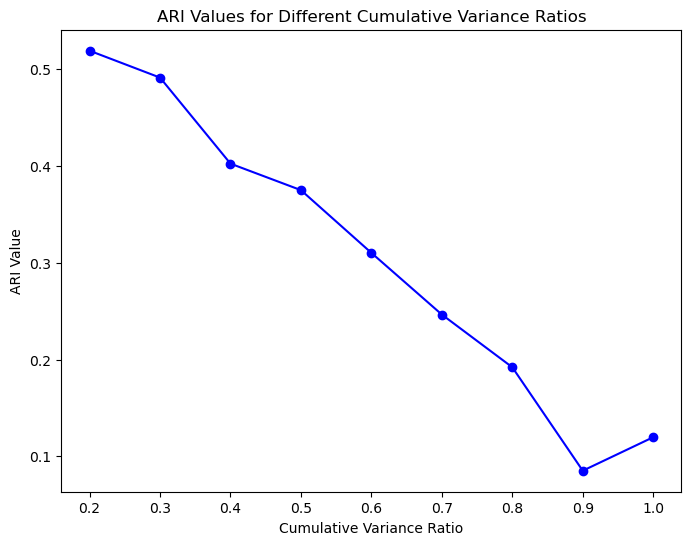

In [56]:
#Plot the line chart of cumulative variance ratio and ARI values.
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_ratios, ari_values, marker='o', linestyle='-', color='b')
plt.title("ARI Values for Different Cumulative Variance Ratios")
plt.xlabel("Cumulative Variance Ratio")
plt.ylabel("ARI Value")
plt.grid(False)
plt.show()

It is observed that as the cumulative explained variance ratio of the selected principal components (ranging between 0.2 and 1) decreases, the Adjusted Rand Index (ARI) values increase, indicating improved clustering performance. This suggests that employing PCA for dimensionality reduction and feature selection effectively reduces noise, thereby enhancing the clustering results achieved through UMAP.

## **4. Model Training and Evaluation**

### **4.1 Data Resampling**
- To address class imbalance, the training data is resampled using oversampling.

In [65]:
df_data_scaled['cell_type'] = df['cell_type']
X = df_data_scaled.iloc[:, :-1]
y = df_data_scaled.iloc[:, -1]  
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [67]:
# Oversample minority classes
X = X_train
y = y_train  

class_counts = y.value_counts()
max_class_count = class_counts.max()

X_resampled = []
y_resampled = []

for class_label in class_counts.index:
    X_class = X[y == class_label]
    y_class = y[y == class_label]
    
    X_class_resampled, y_class_resampled = resample(
        X_class, y_class,
        replace=True,           
        n_samples=max_class_count, 
        random_state=42
    )
    
    X_resampled.append(X_class_resampled)
    y_resampled.append(y_class_resampled)

X_resampled = pd.concat(X_resampled, axis=0)
y_resampled = pd.concat(y_resampled, axis=0)

In [68]:
# Merge the balanced features and labels.
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
# Check the number of new samples for each category.
print(y_resampled.value_counts())

cell_type
0    803
1    803
2    803
3    803
4    803
5    803
6    803
7    803
Name: count, dtype: int64


### **4.2 SVM**
- An SVM model is trained and evaluated on the resampled data.

In [69]:
# Train SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_resampled, y_resampled)

In [70]:
# Evaluate SVM
y_SVM_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_SVM_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_SVM_pred))

Accuracy: 0.9520

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       345
           1       0.92      1.00      0.96       146
           2       0.97      0.98      0.98       102
           3       0.90      0.88      0.89        91
           4       1.00      0.88      0.93        48
           5       1.00      0.76      0.86        45
           6       1.00      0.55      0.71        11
           7       1.00      1.00      1.00         4

    accuracy                           0.95       792
   macro avg       0.97      0.88      0.91       792
weighted avg       0.95      0.95      0.95       792



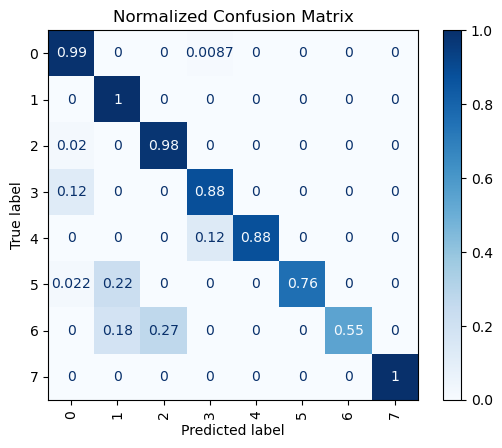

In [72]:
# Plot confusion matrix
cm_normalized = confusion_matrix(y_test, y_SVM_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[0, 1, 2, 3, 4, 5, 6, 7])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix")
plt.show()

### **4.3 XGBoost**
- An XGBoost model is trained and evaluated.

In [ ]:
# Use Bayesian optimization to find the optimal parameters
# Define the objective function
def objectiveXG(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='mlogloss')
    scores = cross_val_score(model, X_resampled, y_resampled, cv=3, scoring='accuracy')
    return scores.mean()

# Start optimization

study = optuna.create_study(direction='maximize')
study.optimize(objectiveXG, n_trials=3)

# Output the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')
final_model.fit(X_resampled, y_resampled)

# Make predictions on new data
y_xgb_pred = final_model.predict(X_test)

Finding the optimal parameters takes too long, so training parameters are obtained through manual tuning.

In [86]:
# Create XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class task
    num_class=len(y.unique()),   # Number of classes
    max_depth=6,                  # Maximum depth of the tree
    learning_rate=0.1,            # Learning rate
    n_estimators=100,             # Number of trees
    use_label_encoder=False,      # Disable automatic label encoding
    random_state=42
)
# Train XGBoost
xgb_model.fit(X_resampled, y_resampled)
# Evaluate XGBoost
y_xgb_pred = xgb_model.predict(X_test)

In [87]:
# Evaluate XGBoost
accuracy = accuracy_score(y_test, y_xgb_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_SVM_pred))

Accuracy: 0.9343

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       345
           1       0.92      1.00      0.96       146
           2       0.97      0.98      0.98       102
           3       0.90      0.88      0.89        91
           4       1.00      0.88      0.93        48
           5       1.00      0.76      0.86        45
           6       1.00      0.55      0.71        11
           7       1.00      1.00      1.00         4

    accuracy                           0.95       792
   macro avg       0.97      0.88      0.91       792
weighted avg       0.95      0.95      0.95       792



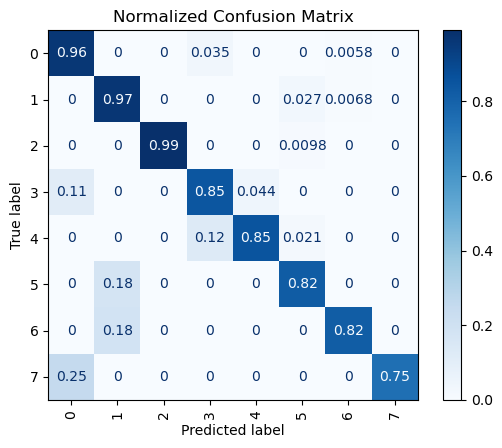

In [88]:
# Plot confusion matrix
cm_normalized = confusion_matrix(y_test, y_xgb_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[0, 1, 2, 3, 4, 5, 6, 7])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix")
plt.show()

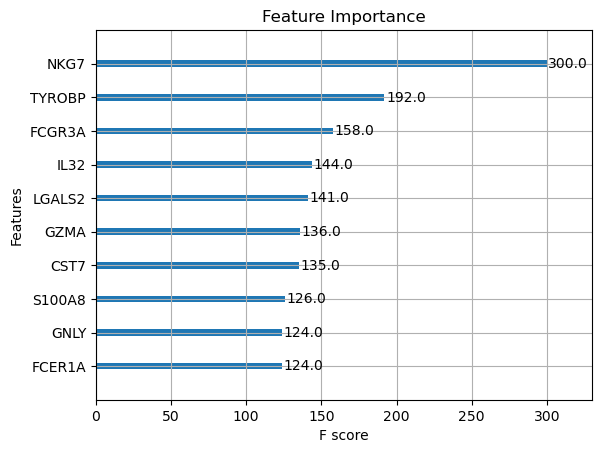

In [89]:
# Feature Importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

### **4.4 Random Forest**
- A Random Forest model is trained and evaluated.

In [ ]:
def objectiveRF(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_categorical('max_depth', [10, 20, None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
    # Create the random forest model
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Evaluate model performance using cross-validation
    score = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()
    return score

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objectiveRF, n_trials=50)

# Output the best parameters and corresponding score
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

# Train the final model using the best parameters
best_params = study.best_params
final_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_rf_model.fit(X_resampled, y_resampled)

# Make predictions on new data
y_rf_pred = final_rf_model.predict(X_test)

Finding the optimal parameters takes too long, so the training of the random forest is achieved through manual tuning of the parameters.

In [100]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Model training
rf_model.fit(X_resampled, y_resampled)
# Model prediction
y_rf_pred = rf_model.predict(X_test)

# Performance evaluation
accuracy = accuracy_score(y_test, y_rf_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_rf_pred))

Accuracy: 0.9242
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       345
           1       0.88      0.97      0.93       146
           2       0.96      0.97      0.97       102
           3       0.85      0.84      0.84        91
           4       0.98      0.85      0.91        48
           5       0.88      0.64      0.74        45
           6       0.80      0.73      0.76        11
           7       1.00      0.75      0.86         4

    accuracy                           0.92       792
   macro avg       0.91      0.84      0.87       792
weighted avg       0.92      0.92      0.92       792



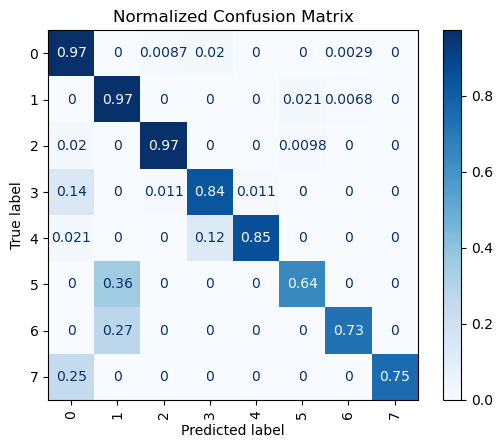

In [101]:
# Plot confusion matrix
cm_normalized = confusion_matrix(y_test, y_rf_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[0, 1, 2, 3, 4, 5, 6, 7])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix")
plt.show()

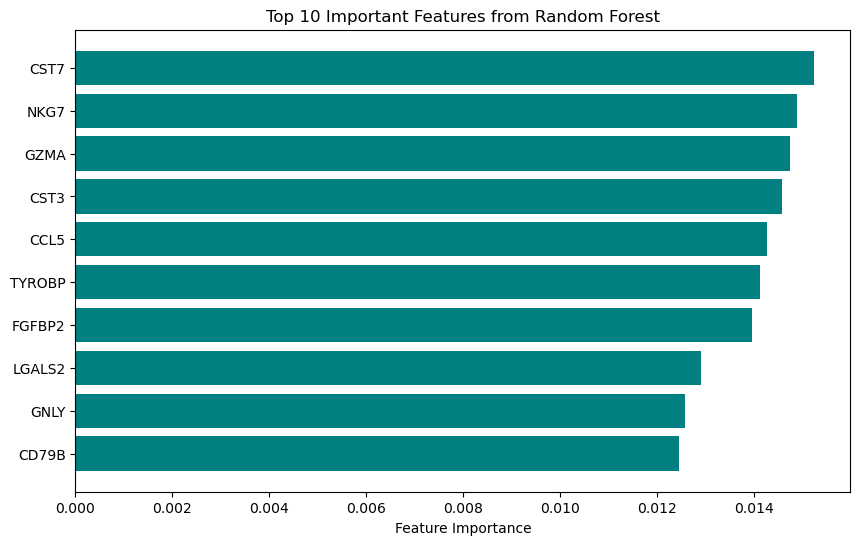

In [102]:
# Get feature importance
importances = rf_model.feature_importances_

# Get feature names (assuming the column names in the DataFrame X are the feature names)
feature_names = X_resampled.columns

# Sort feature names and importance
indices = np.argsort(importances)[::-1]

# Get the top 10 most important features
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = feature_names[top_indices]

# Plot the feature importance as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='teal')
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Important Features from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

In [104]:
X = df_data_scaled.iloc[:, :-1]
y = df_data_scaled.iloc[:, -1]  

# SVM cross-validation
svm_cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
print(f"SVM Accuracy: Mean = {np.mean(svm_cv_scores):.4f}, Std = {np.std(svm_cv_scores):.4f}")

# XGBoost cross-validation
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print(f"XGBoost Accuracy: Mean = {np.mean(xgb_cv_scores):.4f}, Std = {np.std(xgb_cv_scores):.4f}")

# Random Forest cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"Random Forest Accuracy: Mean = {np.mean(rf_cv_scores):.4f}, Std = {np.std(rf_cv_scores):.4f}")

SVM Accuracy: Mean = 0.9238, Std = 0.0093
XGBoost Accuracy: Mean = 0.9522, Std = 0.0028
Random Forest Accuracy: Mean = 0.9253, Std = 0.0040


### **Summary**
#### **Predicting Cell Types Using Gene Expression Data**

This project utilized three methods to predict cell types based on gene expression profiles: Support Vector Machine (SVM), and two ensemble strategies—bagging (Random Forest) and boosting (XGBoost).

##### **Data Preprocessing**
We standardized the data and addressed class label imbalance through oversampling to equalize training samples across eight cell types.

##### **Performance Comparison**
XGBoost was notably slower than SVM and Random Forest due to its sequential training process. Manual parameter tuning was employed after achieving over 0.99 accuracy on the training set. The accuracies were:
- **SVM**: 0.9520
- **Random Forest**: 0.9242
- **XGBoost**: 0.9343

The hierarchy of performance was SVM > XGBoost > Random Forest. All methods showed over 0.99 accuracy on the training set, but accuracy dropped on the test set, with SVM outperforming the ensemble methods. Additionally, minority sample prediction accuracy was lower due to test set imbalance.

##### **Cross-Validation**
Cross-validation with the original dataset revealed XGBoost > Random Forest > SVM in performance and stability, indicating that ensemble methods generally outperform SVM when training and test distributions are similar. Conversely, SVM exhibited better generalization when these distributions differed.

##### **Feature Importance**
Key genes identified by both Random Forest and XGBoost included CTSW, NKG7, S100A8, and TYROBP, highlighting their significance in classifying peripheral blood cell types.